In [1]:
import sys
sys.path.append('../src/')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import scipy
import pickle
import operator
from antenna import Antenna
import itertools
from tqdm import tqdm
from matplotlib import gridspec

In [2]:
with open("../config.json", 'r') as cfg:
    params = json.load(cfg)

antenna_params = params["antenna_params"]
opt_params = params["optimisation_params"]

In [4]:
def compute_possible_conf(N, verbose=0, jac=True, hess=True, maxiter=500):
    antenna_params["N"] = N
    opt_params["options"]["verbose"] = verbose
    opt_params["options"]["maxiter"] = maxiter
    antenna = Antenna(antenna_params)
    antenna.set_objective(weights=[1.0, 1.0])
    configurations = list(itertools.product(np.arange(antenna.n_currents), repeat=antenna.N))
    
    values = []
    for cfg in tqdm(configurations):
        antenna.set_configuration(cfg)
        f, _ = antenna.get_optimal_current_allocation(opt_params, 
                                                      x0=-np.ones(antenna.N), 
                                                      cons=False, 
                                                      jac=jac, 
                                                      hess=hess)
        values.append(f)
    return values, configurations

def currents_plot(N, values, conf, figsize=(20, 5), suffix=''):
    plt.figure(figsize=figsize, dpi=300)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
    
    plt.subplot(gs[0])
    plt.plot(values, '.-r')
    plt.xlim([-0.5, len(values) - 0.5])
    plt.grid(True)

    plt.subplot(gs[1])
    plt.imshow(np.array(conf).T, interpolation='nearest', aspect='auto')
    plt.yticks(np.arange(0.5, N+0.5, 1), labels=[])
    plt.xticks(np.arange(0.5, len(conf)+0.5, 1), labels=[])
    plt.grid(b=True, which='major')
    
    plt.tight_layout()
    plt.savefig(f"../results/imgs/{N}_currents_analysis_{suffix}.png")
    plt.show()

def save_data(N, values, conf, path='../results/calc/'):
    pickle.dump({f"values_{N}": values, f"conf_{N}": conf}, open(path + f"{N}_currents_data.pickle", 'wb'))

def get_data(N, path='../results/calc/'):
    temp = pickle.load(open(path + f"{N}_currents_data.pickle", 'rb'))
    values = temp[f"values_{N}"]
    conf = temp[f"conf_{N}"]
    return values, conf

def get_conf_dict(values, conf):
    return dict(zip(conf, values))

def gray_code(n):
    def gray_code_recurse (g, n):
        k = len(g)
        if n <= 0:
            return
        else:
            for i in range (k-1,-1,-1):
                char='1,' + g[i]
                g.append(char)
            for i in range (k-1,-1,-1):
                g[i]='0,' + g[i]
            gray_code_recurse(g,n-1)
    g = ['0', '1']
    gray_code_recurse(g,n-1)
    return g

def gray_code_repr(conf_dict):
    N = len(list(conf_dict.keys())[0])
    gray_conf = gray_code(N)
    conf_dict_gray = {}
    for k in gray_conf:
        conf_elem = tuple([int(e) for e in k.split(',')])
        conf_dict_gray[conf_elem] = conf_dict[conf_elem]
    return conf_dict_gray

def sorted_repr(conf_dict):
    sorted_dict = sorted(conf_dict.items(), key=operator.itemgetter(1))
    return dict(sorted_dict)

In [6]:
values10_num, conf10 = compute_possible_conf(10, jac=False, hess=False)
print(f"obj function value for the optimal configuration: {min(values10_num)}")

  0%|          | 0/1024 [00:00<?, ?it/s]/home/sergey/.conda/envs/kaggle/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
100%|██████████| 1024/1024 [06:03<00:00,  2.93it/s]

obj function value for the optimal configuration: 157.9979314876113


In [7]:
save_data(10, values=values10_num, conf=conf10)

In [5]:
values10_num, conf10 = get_data(10)

In [6]:
conf10_values = get_conf_dict(values10_num, conf10)
conf10_values_sorted = sorted_repr(conf10_values)

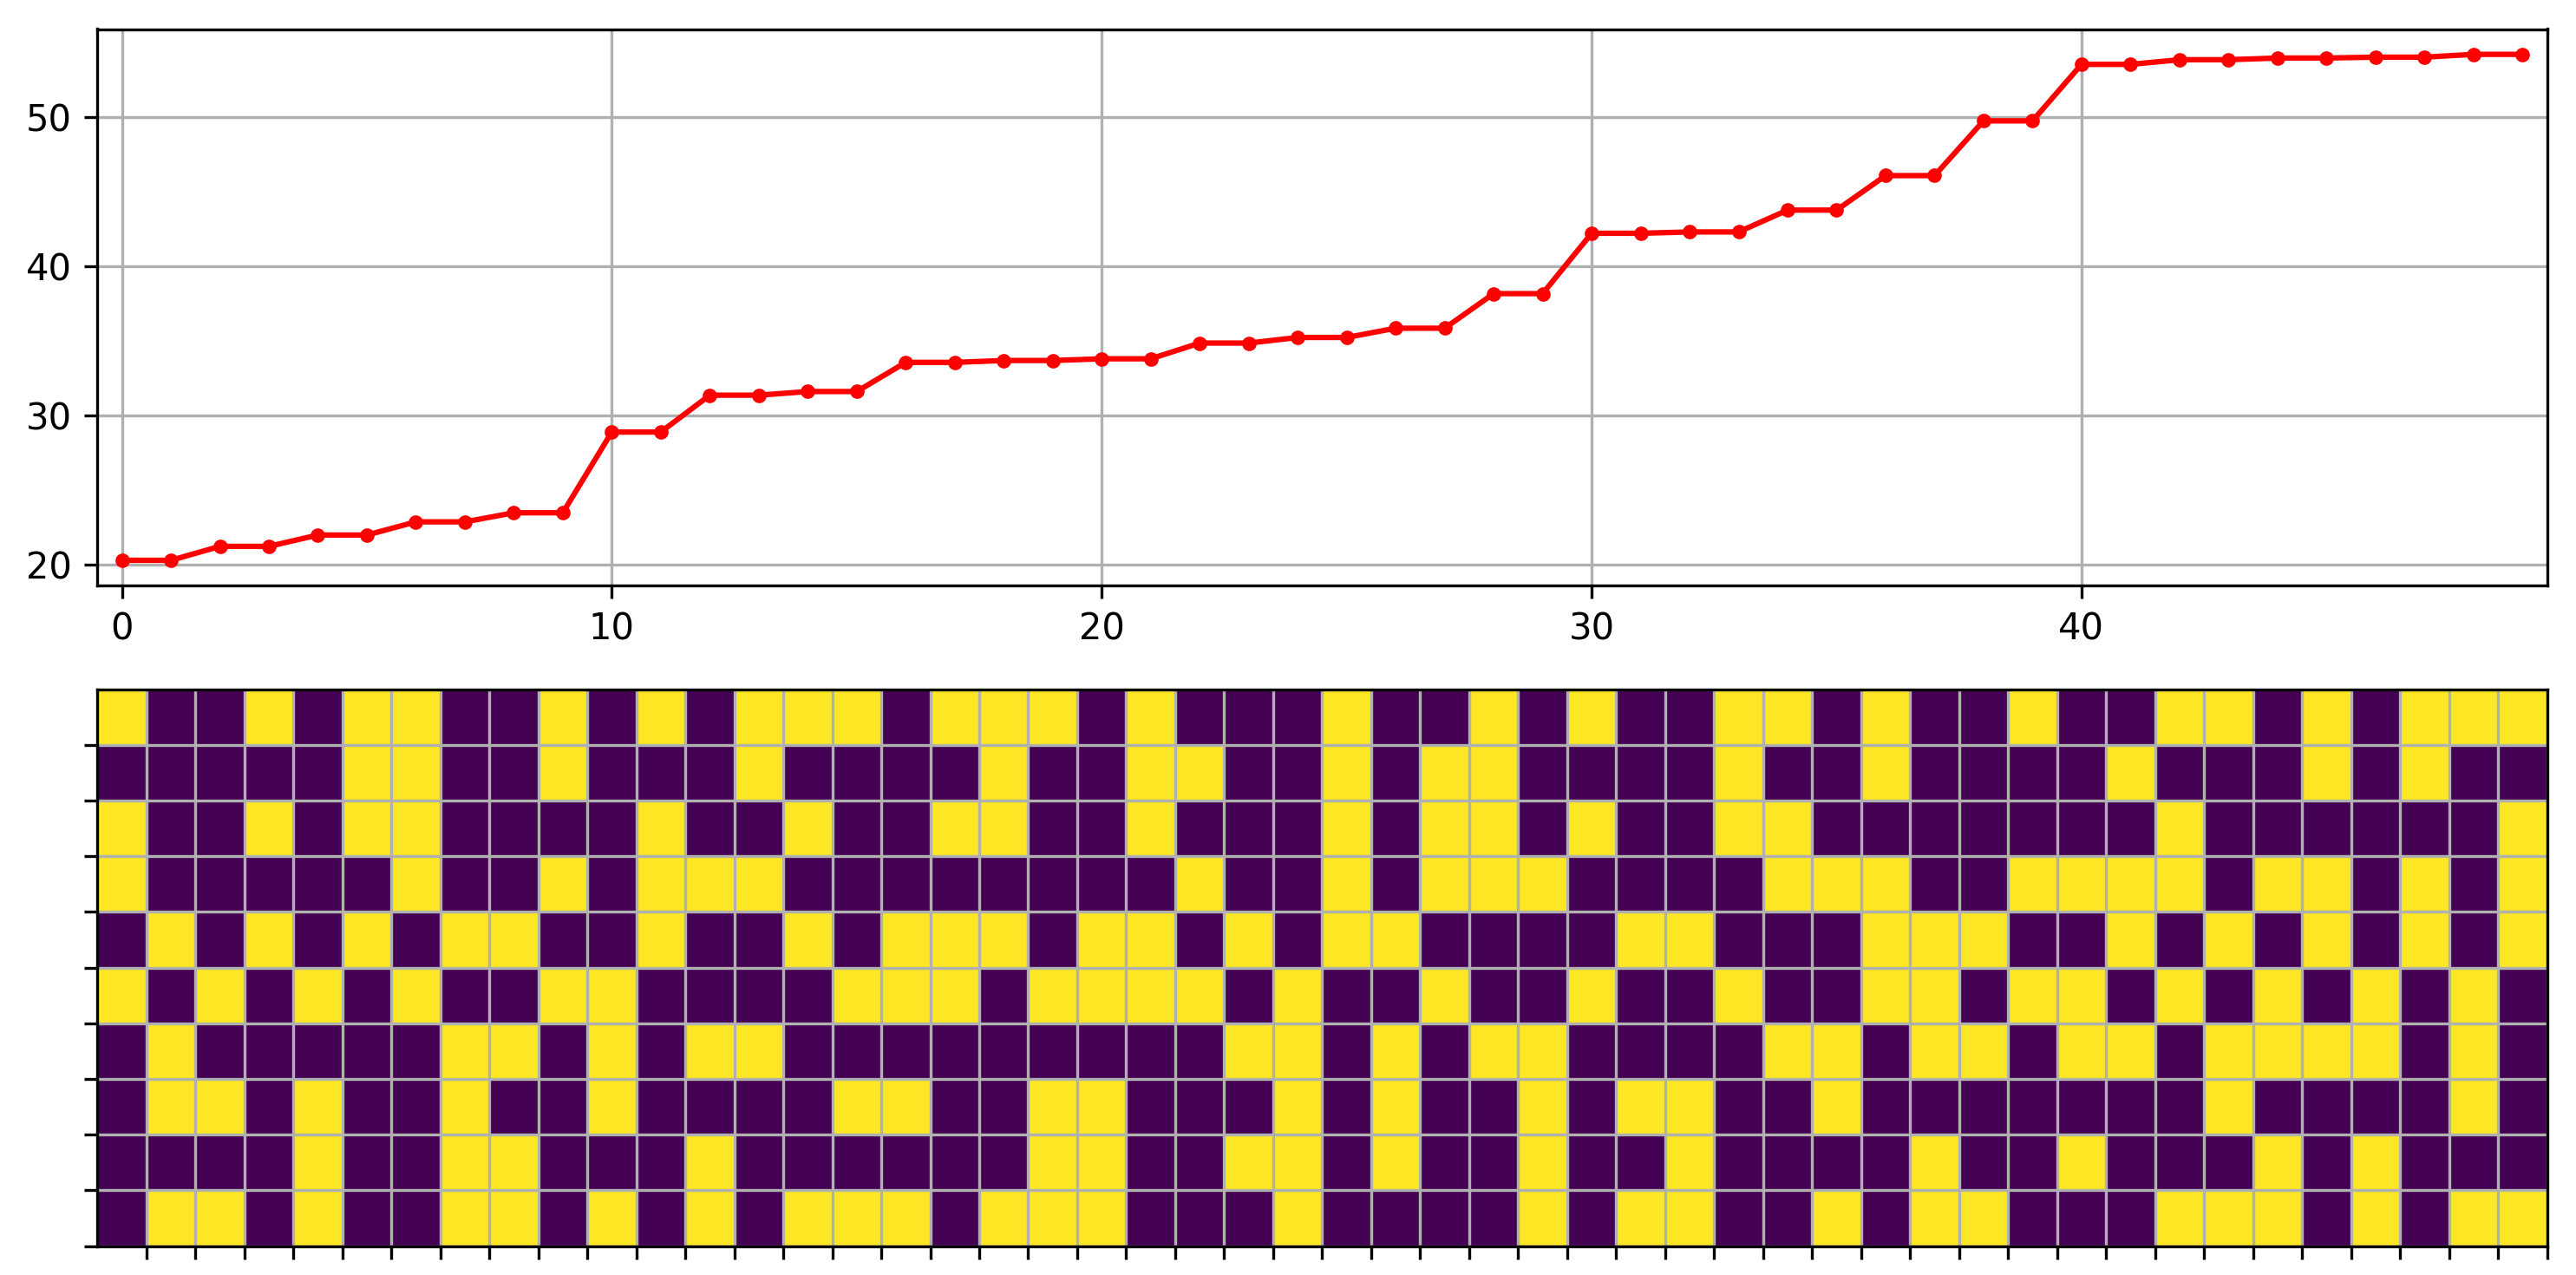

In [7]:
currents_plot(10, 
              list(conf10_values_sorted.values())[:50], 
              list(conf10_values_sorted.keys())[:50], 
              figsize=(10, 5), suffix='top30')

In [8]:
antenna_params["wavelengths"]=[1, 2]
antenna = Antenna(antenna_params)
antenna.set_configuration([1, 0, 1, 1, 0, 1, 0, 0, 0, 0])
antenna.set_objective([1.0, 1.0])

In [9]:
antenna.get_optimal_current_allocation(opt_params, x0=-np.ones(antenna.N), cons=False)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |  11   |   0   | +6.5369e+02 | 1.00e+00 | 2.80e+02 | 0.00e+00 | 1.00e+00 |   0   |
|   2   |  22   |   1   | +1.0671e+02 | 7.00e+00 | 1.92e+02 | 0.00e+00 | 1.00e+00 |   2   |
|   3   |  33   |   3   | +1.0671e+02 | 7.00e-01 | 1.92e+02 | 0.00e+00 | 1.00e+00 |   4   |
|   4   |  44   |   5   | +7.5180e+01 | 1.40e+00 | 1.51e+02 | 0.00e+00 | 1.00e+00 |   2   |
|   5   |  55   |   7   | +7.5180e+01 | 7.00e-01 | 1.51e+02 | 0.00e+00 | 1.00e+00 |   2   |
|   6   |  66   |   9   | +7.5180e+01 | 3.50e-01 | 1.51e+02 | 0.00e+00 | 1.00e+00 |   2   |
|   7   |  77   |  11   | +4.4745e+01 | 7.00e-01 | 5.65e+01 | 0.00e+00 | 1.00e+00 |   2   |
|   8   |  88   |  15   | +4.4164e+01 | 7.00e-01 | 8.84e+01 | 0.00e+00 | 1.00e+00 |   4   |
|   9   |  99   |  19   | +3.3816e+01 | 1.19e+00 | 5.57e+01 | 0.00e+00 | 1.00e+0

(20.187619007850454,
 array([-0.63204151, -2.44672613, -0.61678295, -0.27361131, -0.92783134,
        -0.28078239, -0.7941193 , -0.48918273, -0.54136807, -0.90209833]))

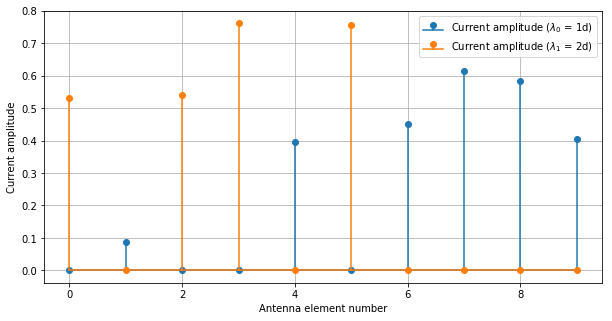

In [10]:
antenna.plot_current_distribution()

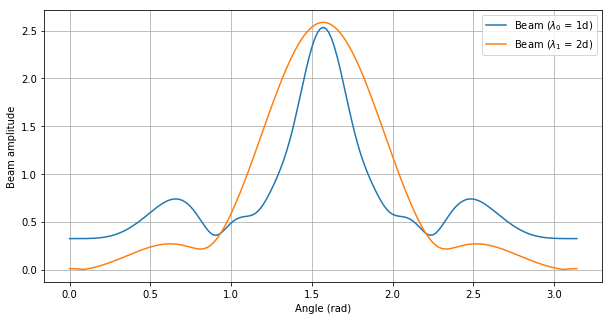

In [11]:
antenna.plot_formed_beams()